# Zachłanne kolorowanie grafów

## Wprowadzenie

Kolorowanie grafu to przypisywanie kolorów jego wierzchołkom w taki sposób, aby żadne dwa sąsiednie wierzchołki nie miały tego samego koloru. Jest to klasyczny problem teorii grafów o wielu zastosowaniach, m.in. w harmonogramowaniu, przydzielaniu zasobów czy rozwiązywaniu problemów map kolorowania.

Rozpocznijmy nasze zmagania z tym problemem od wygenerowania i zwizualizowania początkowego grafu.

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo

In [5]:
def visualize_coloring(graph, coloring=None, title="Graph Coloring"):
    G = nx.Graph()
    for node, neighbors in graph.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    pos = nx.spring_layout(G, seed=42)

    if coloring:
        num_colors = max(coloring.values()) + 1
        color_map = plt.cm.get_cmap('tab10', num_colors)
        node_colors = [color_map(coloring[node]) for node in G.nodes()]
    else:
        node_colors = 'lightblue'

    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=500,
        edge_color='gray'
    )
    plt.title(title)
    plt.show()

def generate_random_graph(num_nodes, edge_prob):
    graph = defaultdict(list)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if random.random() < edge_prob:
                graph[i].append(j)
                graph[j].append(i)
    return graph

def find_vertex_with_max_degree(graph):
    max_vertex = None
    max_degree = -1
    for node, neighbors in graph.items():
        degree = len(neighbors)
        if degree > max_degree:
            max_degree = degree
            max_vertex = node
    return max_vertex, max_degree

In [6]:
num_nodes = 10
edge_prob = 0.3

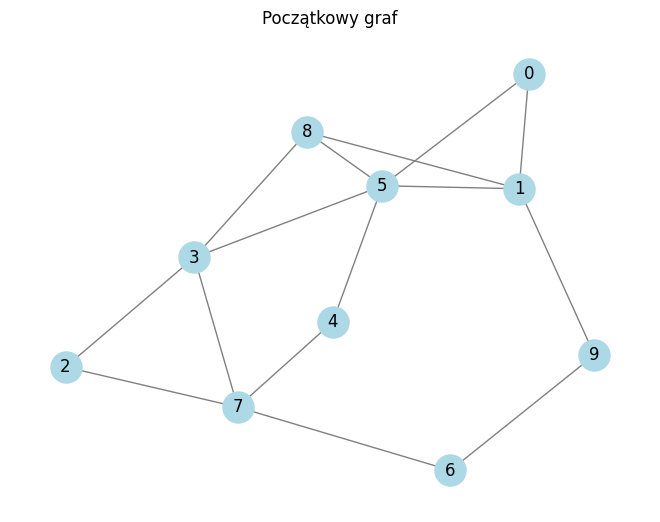

In [7]:
graph = generate_random_graph(num_nodes, edge_prob)
visualize_coloring(graph, title="Początkowy graf")

# Podstawowy algorytm zachłanny

Jednym z najprostszych i najszybszych algorytmów kolorowania jest **algorytm zachłanny**. Działa on w sposób sekwencyjny – każdy wierzchołek otrzymuje pierwszy dostępny kolor, który nie został jeszcze przypisany jego sąsiadom. Chociaż algorytm ten nie gwarantuje użycia minimalnej liczby kolorów (czyli tzw. liczby chromatycznej), często daje dobre wyniki przy bardzo niskim koszcie obliczeniowym.

In [8]:
def greedy_coloring(graph):
    colors = {}
    for node in graph:
        neighbor_colors = {colors[neighbor] for neighbor in graph[node] if neighbor in colors}
        color = 0
        while color in neighbor_colors:
            color += 1
        colors[node] = color
    num_colors = max(colors.values()) + 1
    return colors, num_colors

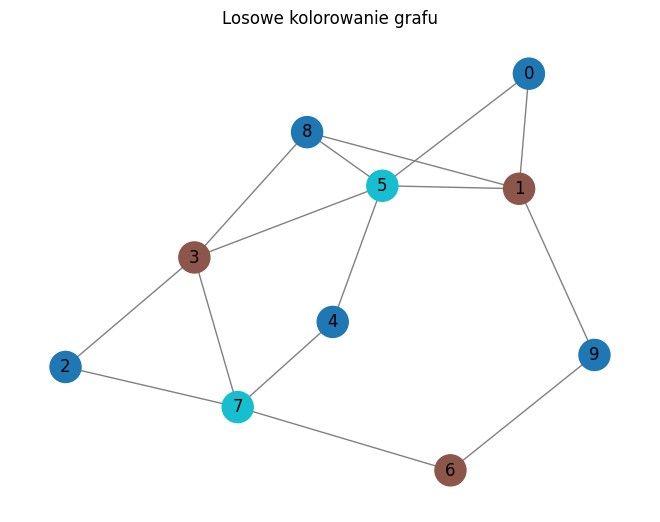

In [9]:
coloring, num_colors = greedy_coloring(graph)
visualize_coloring(graph, coloring, title="Losowe kolorowanie grafu")

# Algorytm zachłanny Largest First - Algorytm Welsh-Powell

Algorytm Welsh-Powell to klasyczna heurystyka zachłanna stosowana do kolorowania wierzchołków grafu.
Polega na sortowaniu wierzchołków malejąco według ich stopnia (czyli liczby sąsiadów), a następnie przydzielaniu
kolejnych kolorów w tej kolejności. Dzięki temu węzły o największym wpływie na strukturę grafu są kolorowane najpierw,
co w praktyce często skutkuje użyciem mniejszej liczby kolorów niż w przypadku prostego kolorowania w kolejności losowej.

**Kroki algorytmu:**
1. Posortuj wierzchołki malejąco według stopnia.
2. Dla każdego wierzchołka w tej kolejności przypisz pierwszy dostępny kolor, który nie występuje u jego sąsiadów.


In [10]:
def welsh_powell(graph):
    # Posortuj wierzchołki malejąco według stopnia
    nodes = sorted(graph, key=lambda x: len(graph[x]), reverse=True)
    colors = {}
    for node in nodes:
        neighbor_colors = {colors[neighbor] for neighbor in graph[node] if neighbor in colors}
        color = 0
        while color in neighbor_colors:
            color += 1
        colors[node] = color
        num_colors = max(colors.values()) + 1
    return colors, num_colors

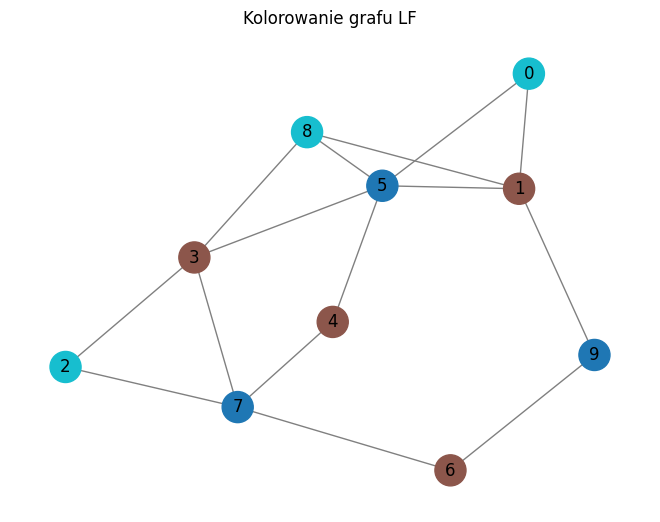

In [11]:
coloring, num_colors = welsh_powell(graph)
visualize_coloring(graph, coloring, title="Kolorowanie grafu LF")

# Algorytm zachłanny Smallest Last

Algorytm Smallest Last to heurystyka, która najpierw ustala kolejność kolorowania poprzez iteracyjne usuwanie
wierzchołka o najmniejszym stopniu (czyli z najmniejszą liczbą sąsiadów), zapamiętując kolejność usuwania.
Następnie koloruje graf w odwrotnej kolejności do tej ustalonej – zaczynając od wierzchołka usuniętego jako ostatni.

Dzięki temu algorytm zazwyczaj unika nadmiernego zużycia kolorów, ponieważ wierzchołki, które są mniej "problematyczne",
kolorowane są na końcu, gdy więcej kolorów jest już przypisanych sąsiadom.

**Kroki algorytmu:**
1. Iteracyjnie usuwaj wierzchołki o najmniejszym stopniu, zapamiętując ich kolejność.
2. Koloruj wierzchołki w odwrotnej kolejności przydzielając pierwszy dostępny kolor.


In [21]:
def smallest_last_coloring(graph):
    # Kopia grafu do modyfikacji
    temp_graph = {node: set(neighbors) for node, neighbors in graph.items()}
    degrees_at_removal = {}

    # Tworzenie kolejności Smallest Last i zapamiętanie stopni
    order = []
    while temp_graph:
        # Znajdź węzeł o najmniejszym stopniu
        smallest_node = min(temp_graph, key=lambda node: len(temp_graph[node]))
        degree = len(temp_graph[smallest_node])
        degrees_at_removal[smallest_node] = degree
        order.append(smallest_node)

        # Usuń węzeł z grafu
        for neighbor in temp_graph[smallest_node]:
            temp_graph[neighbor].remove(smallest_node)
        del temp_graph[smallest_node]


    # Kolorowanie w odwrotnej kolejności
    colors = {}
    for node in reversed(order):
        neighbor_colors = {colors[neighbor] for neighbor in graph[node] if neighbor in colors}
        color = 0
        while color in neighbor_colors:
            color += 1
        colors[node] = color
        num_colors = max(colors.values()) + 1
        
    # Liczba kolorująca to maksymalny stopień w momencie usunięcia + 1
    max_degree_at_removal = max(degrees_at_removal.values(), default=0)
    coloring_num = max_degree_at_removal + 1

    return colors, num_colors, coloring_num

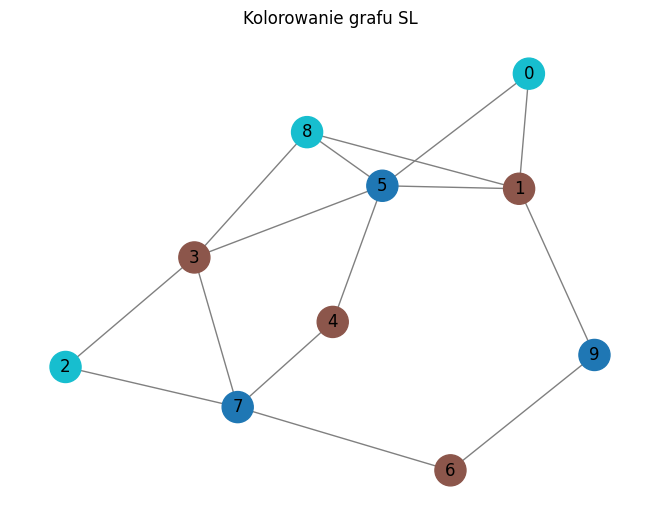

In [22]:
colors, num_colors, coloring_num = smallest_last_coloring(graph)
visualize_coloring(graph, coloring, title="Kolorowanie grafu SL")

In [23]:
coloring_num

3

# Porównanie

Sprawdźmy teraz jak poszczególny algorytm działa na grafach z od 5 do 1000 wierzchołków.

In [24]:
c_random = []
c_LF = []
c_SL = []
c_SL_cnu = []
edge_prob = 0.3

for i in range(5, 1000):
    random_graph = generate_random_graph(i, edge_prob)
    coloring_random, nc_random = greedy_coloring(random_graph)
    coloring_LF, nc_LF = welsh_powell(random_graph)
    coloring_SL, nc_SL, chromatic_number = smallest_last_coloring(random_graph)
    c_random.append(nc_random)
    c_LF.append(nc_LF)
    c_SL.append(nc_SL)
    c_SL_cnu.append(chromatic_number)

In [25]:
pyo.init_notebook_mode(connected=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(c_random)+1)), y=c_random, mode='lines+markers', name='Kolorowanie losowe'))
avg_random = sum(c_random) / len(c_random)
fig.add_trace(go.Scatter(x=list(range(1, len(c_random)+1)),y=[avg_random] * len(c_random),mode='lines',name=f'Średnia losowe (średnia: {avg_random:.2f})',line=dict(dash='dash', color='blue'),hoverinfo='text',text=[f'Średnia kolorowanie losowe: {avg_random:.2f}'] * len(c_random)))

fig.add_trace(go.Scatter(x=list(range(1, len(c_LF)+1)), y=c_LF, mode='lines+markers', name='Kolorowanie LF'))
avg_LF = sum(c_LF) / len(c_LF)
fig.add_trace(go.Scatter(x=list(range(1, len(c_LF)+1)),y=[avg_LF] * len(c_LF),mode='lines',name=f'Średnia LF (średnia: {avg_LF:.2f})',line=dict(dash='dash', color='orange'),hoverinfo='text',text=[f'Średnia kolorowanie LF: {avg_LF:.2f}'] * len(c_LF)))

fig.add_trace(go.Scatter(x=list(range(1, len(c_SL)+1)), y=c_SL, mode='lines+markers', name='Kolorowanie SL'))
avg_SL = sum(c_SL) / len(c_SL)
fig.add_trace(go.Scatter(x=list(range(1, len(c_SL)+1)),y=[avg_SL] * len(c_SL),mode='lines',name=f'Średnia SL (średnia: {avg_SL:.2f})',line=dict(dash='dash', color='green'),hoverinfo='text',text=[f'Średnia kolorowanie SL: {avg_SL:.2f}'] * len(c_SL)))

fig.update_layout(title='Liczba użytych kolorów', xaxis_title='Liczba wierzchołków',yaxis_title='Użyte kolory',title_font_size=24,title_x=0.5,xaxis_title_font_size=18,yaxis_title_font_size=18,font=dict(family="Arial, sans-serif", size=14),template='plotly_dark')
fig.show()

Jak możemy zauważyć do grafów z 100 wierzchołkami ilość użytych kolorów przez odpowiednie algorytmy jest porównywalnie taka sama. Magia sie dzieje w momencie kiedy używamy grafów z 100+ wierzchołakmi. Wtedy możemy zauważyć, że kolorowanie losowe wykorzystuje znacznie większą liczbę kolorów od pozostałych algorytmów. Kolorowanie LF i SL wygląda podobnie, jednak z delikatną przewagą dla pierwszego algorytmu.
Końcowy wynik również to pokazuje, gdyż ranking średnich kolorów użytych do pokolorowania wszystkich grafów wygląda następująco:
- Kolorowanie LF --> średnia 41.32 użytego koloru
- Kolorowanie SL --> średnia 42.04 użytego koloru
- Kolorowanie losowe --> średnia 43.43 użytego koloru

Należy też zauważyć, że te odchyły są skutkiem tego, że braliśmy wszystkie grafy pod względem liczenia średniej - te z 5 wierzchołkami oraz te z 1000 wierzchołków.

In [26]:
pyo.init_notebook_mode(connected=True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(c_SL)+1)), y=c_SL, mode='lines+markers', name='Kolorowanie SL'))
fig.add_trace(go.Scatter(x=list(range(1, len(c_SL_cnu)+1)), y=c_SL_cnu, mode='lines+markers', name='Liczba kolorująca'))
fig.update_layout(title='Liczba użytych kolorów', xaxis_title='Liczba wierzchołków',yaxis_title='Użyte kolory',title_font_size=24,title_x=0.5,xaxis_title_font_size=18,yaxis_title_font_size=18,font=dict(family="Arial, sans-serif", size=14),template='plotly_dark')
fig.show()